In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

print("Библиотеки импортированы.")

Библиотеки импортированы.


In [2]:
filename = 'final_sensor_table_sorted.csv'
try:
    df = pd.read_csv(filename)
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='ISO8601')  
    #Делаем колонку с датой индексом таблицы
    df.set_index('timestamp', inplace=True)
    
    print(f" Файл загружен. {df.shape[0]} строк.")  
except FileNotFoundError:
    print(f" Файл '{filename}' не найден.")
    raise

 Файл загружен. 8189891 строк.


In [6]:
# Подготовка данных

print("\nПодготовка данных для кластеризации")
features_for_stats = [
    'Vessel External Conditions Eastward Wind Velocity',
    'Vessel External Conditions Northward Wind Velocity',
    'Vessel External Conditions Sea Water Temperature',
    'Vessel External Conditions Swell Significant Height',
    'Vessel External Conditions Wave Period',
    'Vessel External Conditions Wave Significant Height',
    'Vessel Hull Relative To Transducer Water Depth',
    'Vessel Hull Aft Draft',
    'Vessel Hull Fore Draft',
    'Vessel Hull MidP Draft',
    'Vessel Hull MidS Draft'
]
features_for_stats = [col for col in features_for_stats if col in df.columns]

resampler = df[features_for_stats].resample('1h')

# Для каждой группы считаем среднее и стандартное отклонение
resampled_mean = resampler.mean()
resampled_std = resampler.std()

resampled_mean.columns = [f"{col}_mean" for col in resampled_mean.columns]
resampled_std.columns = [f"{col}_std" for col in resampled_std.columns]

resampled_data = pd.concat([resampled_mean, resampled_std], axis=1)

# Заполняем все пропуски, которые могли возникнуть при расчете std, нулями
resampled_data.fillna(0, inplace=True)

print(f"Данные агрегированы по 1-часовым интервалам с расчетом 'mean' и 'std'.")
print(f"Количество признаков для кластеризации: {len(resampled_data.columns)}")
cluster_data = resampled_data.dropna().copy()
print(f"\nДля кластеризации будет использовано {len(cluster_data)} строк.")

if cluster_data.empty:
    raise ValueError("Таблица для кластеризации пуста. Попробуйте использовать меньше признаков.")

# Стандартизируем данные
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)
print("Данные стандартизированы и готовы к кластеризации.")


Подготовка данных для кластеризации
Данные агрегированы по 1-часовым интервалам с расчетом 'mean' и 'std'.
Количество признаков для кластеризации: 20

Для кластеризации будет использовано 8784 строк.
Данные стандартизированы и готовы к кластеризации.


In [7]:
# Запуск кластеризации
n_clusters = 250
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')

# Обучаем модель: она находит центры и присваивает каждой часовой отметке номер кластера
cluster_labels = kmeans.fit_predict(scaled_data)
print("Кластеризация завершена.")

# Добавляем номер кластера в таблицу с часовыми данными
cluster_data['cluster'] = cluster_labels

Кластеризация завершена.


In [10]:
# Анализ результатов
print("\nАнализ результатов кластеризации")

# Определяем, какие колонки нам нужны для финального анализа
analysis_cols = [
    'Vessel Hull Through Water Longitudinal Speed',
    'Vessel Propeller Shaft Mechanical Power'
]
analysis_cols = [col for col in analysis_cols if col in df.columns]
analysis_df = df[analysis_cols].resample('1h').mean()

# Объединяем результаты кластеризации с нашей аналитической таблицей
analysis_df = analysis_df.join(cluster_data['cluster'], how='inner')
print(f"Создана аналитическая таблица. В ней {len(analysis_df)} часов с полной информацией.")

cluster_sizes = analysis_df['cluster'].value_counts()
speed_variation = analysis_df.groupby('cluster')['Vessel Hull Through Water Longitudinal Speed'].std() # <-- ИЗМЕНЕНИЕ ЗДЕСЬ
interesting_clusters = cluster_sizes.head(10).index
valid_interesting_clusters = [c for c in interesting_clusters if c in speed_variation.index]

if not valid_interesting_clusters:
    example_cluster_id = int(cluster_sizes.index[0])
else:
    example_cluster_id = int(speed_variation.loc[valid_interesting_clusters].idxmax())

print(f"\nВыбран кластер №{example_cluster_id} для детального анализа.")
print(f"Этому кластеру соответствуют {cluster_sizes.loc[example_cluster_id]} часов с похожими условиями.")

# Фильтруем аналитическую таблицу
example_cluster_df = analysis_df[analysis_df['cluster'] == example_cluster_id]

print("\nСредние условия в выбранном кластере (статистики 'mean' и 'std'):")
print(cluster_data[cluster_data['cluster'] == example_cluster_id].mean().T.to_string())


Анализ результатов кластеризации
Создана аналитическая таблица. В ней 8784 часов с полной информацией.

Выбран кластер №172 для детального анализа.
Этому кластеру соответствуют 197 часов с похожими условиями.

Средние условия в выбранном кластере (статистики 'mean' и 'std'):
Vessel External Conditions Eastward Wind Velocity_mean        0.000000
Vessel External Conditions Northward Wind Velocity_mean       0.000000
Vessel External Conditions Sea Water Temperature_mean         0.000000
Vessel External Conditions Swell Significant Height_mean      0.003553
Vessel External Conditions Wave Period_mean                   0.000000
Vessel Hull Relative To Transducer Water Depth_mean           0.298486
Vessel Hull Aft Draft_mean                                    0.000000
Vessel Hull Fore Draft_mean                                   0.000000
Vessel Hull MidP Draft_mean                                   0.000000
Vessel Hull MidS Draft_mean                                   0.000000
Vessel Extern


--- Построение графика для выбранного кластера ---

Признаки, используемые для финального графика:
  Ось X: Vessel Hull Through Water Longitudinal Speed
  Ось Y: Vessel Propeller Shaft Mechanical Power



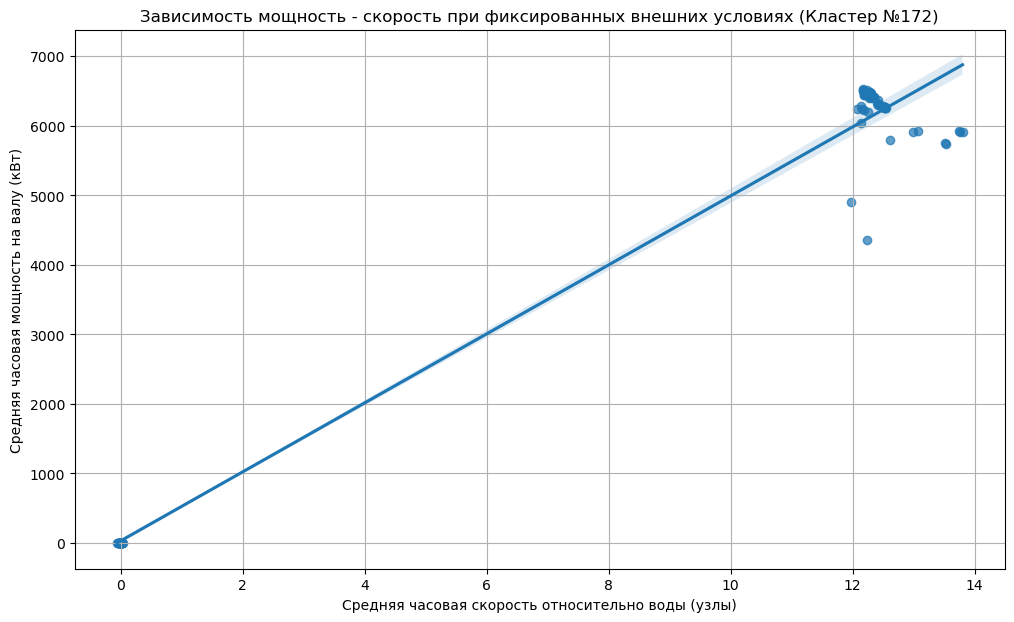


Анализ завершен.


In [12]:
#График
print("\n--- Построение графика для выбранного кластера ---")

plot_x_variable = 'Vessel Hull Through Water Longitudinal Speed'
plot_y_variable = 'Vessel Propeller Shaft Mechanical Power'

print("\nПризнаки, используемые для финального графика:")
print(f"  Ось X: {plot_x_variable}")
print(f"  Ось Y: {plot_y_variable}\n")

plt.figure(figsize=(12, 7))
sns.regplot(data=example_cluster_df, 
            x=plot_x_variable, 
            y=plot_y_variable,
            scatter_kws={'alpha':0.7})

plt.title(f'Зависимость мощность - скорость при фиксированных внешних условиях (Кластер №{example_cluster_id})')
# Меняем подпись оси X
plt.xlabel('Средняя часовая скорость относительно воды (узлы)')
plt.ylabel('Средняя часовая мощность на валу (кВт)')
plt.grid(True)
plt.show()

print("\nАнализ завершен.")